In [48]:
# CELLULE 1 : IMPORTS COMPLETS ET CONFIGURATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.impute import SimpleImputer

# Configuration pour l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")

print("✅ Bibliothèques importées et configurées")
print("=" * 50)

✅ Bibliothèques importées et configurées


# Exploration des données SECOM
Ce notebook est dédié à l'analyse exploratoire des données (EDA) du dataset Semiconductor Manufacturing.

In [49]:
# CELLULE 2 : CHARGEMENT DES DONNÉES
print("📊 CHARGEMENT DES DONNÉES SECOM")
print("=" * 50)

# Chemin vers le fichier
data_path = "../data/uci-secom.csv"

# Chargement avec vérification
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"✅ Données chargées avec succès")
    print(f"   • Dimensions : {df.shape}")
    print(f"   • Lignes : {df.shape[0]}, Colonnes : {df.shape[1]}")
    
    # Afficher les premières lignes
    print(f"\n👀 Aperçu des données (3 premières lignes) :")
    print(df.head(3))
    
    # Afficher les noms des colonnes
    print(f"\n📋 Liste des colonnes (20 premières) :")
    for i, col in enumerate(df.columns[:20]):
        print(f"   {i:3d}. {col}")
else:
    print(f"❌ Fichier non trouvé : {data_path}")

📊 CHARGEMENT DES DONNÉES SECOM
✅ Données chargées avec succès
   • Dimensions : (1567, 593)
   • Lignes : 1567, Colonnes : 593

👀 Aperçu des données (3 premières lignes) :
                  Time        0        1          2          3       4      5         6       7       8       9      10      11        12   13       14        15       16      17        18       19      20       21       22       23       24      25      26      27       28      29      30      31       32      33       34       35       36       37       38        39     40     41    42        43       44        45        46      47        48   49        50        51   52     53     54      55      56      57      58       59        60       61        62       63       64       65        66      67        68   69        70       71        72        73   74      75      76      77      78      79      80      81      82      83      84  85      86      87         88      89         90      91      92      93      94 

In [50]:
# CELLULE 3 : IDENTIFICATION DE LA COLONNE CIBLE
print("\n🎯 IDENTIFICATION DE LA COLONNE CIBLE")
print("=" * 50)

# Chercher la colonne cible par nom
target_candidates = ['Pass/Fail', 'pass/fail', 'PassFail', 'passfail', 
                     'Target', 'target', 'Class', 'class', 'Label', 'label']

target_col = None
for candidate in target_candidates:
    if candidate in df.columns:
        target_col = candidate
        print(f"✓ Colonne cible trouvée : '{target_col}'")
        break

if target_col:
    # Afficher les informations sur la colonne cible
    print(f"\n📊 ANALYSE DE LA COLONNE CIBLE '{target_col}' :")
    print(f"   • Type de données : {df[target_col].dtype}")
    print(f"   • Valeurs uniques : {df[target_col].unique()}")
    print(f"   • Distribution :")
    print(df[target_col].value_counts(dropna=False))
    
    # Calculer les proportions
    proportions = df[target_col].value_counts(normalize=True, dropna=False)
    print(f"\n   • Proportions :")
    for val, prop in proportions.items():
        print(f"     - {val} : {prop:.2%}")
    
    # Vérifier si c'est -1/1 et convertir en 0/1
    unique_vals = df[target_col].dropna().unique()
    if set(unique_vals) == {-1, 1}:
        print(f"\n🔄 Format détecté : -1/1 (convertir en 0/1)")
        # On convertira plus tard après la séparation
else:
    print("❌ Aucune colonne cible standard trouvée")
    
    # Chercher des colonnes binaires
    print("\n🔍 Recherche de colonnes binaires...")
    binary_cols = []
    for col in df.columns:
        if df[col].nunique() == 2:
            binary_cols.append((col, df[col].unique()))
    
    if binary_cols:
        print(f"   • Colonnes binaires trouvées ({len(binary_cols)}) :")
        for col, vals in binary_cols[:5]:  # Afficher les 5 premières
            print(f"     - {col} : {vals}")
        
        # Prendre la dernière colonne binaire comme cible (probablement Pass/Fail)
        target_col = binary_cols[-1][0]
        print(f"\n✓ Colonne cible sélectionnée : '{target_col}'")
    else:
        print("❌ Aucune colonne binaire trouvée")
        target_col = df.columns[-1]  # Dernière colonne par défaut
        print(f"⚠️  Utilisation de la dernière colonne : '{target_col}'")


🎯 IDENTIFICATION DE LA COLONNE CIBLE
✓ Colonne cible trouvée : 'Pass/Fail'

📊 ANALYSE DE LA COLONNE CIBLE 'Pass/Fail' :
   • Type de données : int64
   • Valeurs uniques : [-1  1]
   • Distribution :
Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64

   • Proportions :
     - -1 : 93.36%
     - 1 : 6.64%

🔄 Format détecté : -1/1 (convertir en 0/1)


In [51]:
# CELLULE 4 : PRÉTRAITEMENT DES DONNÉES
print("\n🔧 ÉTAPE 3 : PRÉTRAITEMENT DES DONNÉES")
print("=" * 50)

# Copie du dataframe original pour le prétraitement
df_processed = df.copy()

# 1. Supprimer la colonne 'Time' si elle existe
if 'Time' in df_processed.columns:
    df_processed = df_processed.drop(columns=['Time'])
    print("1. ✓ Colonne 'Time' supprimée")
else:
    print("1. ℹ️ Colonne 'Time' non trouvée")

# 2. Vérifier et encoder 'Phase' si elle existe
if 'Phase' in df_processed.columns:
    print(f"\n2. ENCODAGE DE 'Phase' :")
    print(f"   • Type : {df_processed['Phase'].dtype}")
    print(f"   • Valeurs uniques : {df_processed['Phase'].unique()}")
    print(f"   • Nombre de valeurs uniques : {df_processed['Phase'].nunique()}")
    
    # One-hot encoding
    df_processed = pd.get_dummies(df_processed, columns=['Phase'], prefix='Phase', drop_first=True)
    print(f"   ✓ One-hot encoding terminé")
    print(f"   • Nouvelles dimensions : {df_processed.shape}")
else:
    print("2. ℹ️ Colonne 'Phase' non trouvée")

# 3. Séparation X et y
print(f"\n3. SÉPARATION DES FEATURES ET DE LA CIBLE :")

if target_col in df_processed.columns:
    X = df_processed.drop(columns=[target_col])
    y = df_processed[target_col]
    
    print(f"   ✓ Séparation réussie")
    print(f"   • X (features) : {X.shape}")
    print(f"   • y (target) : {y.shape}")
    
    # Conversion de y si nécessaire (-1/1 → 0/1)
    unique_vals = y.dropna().unique()
    if set(unique_vals) == {-1, 1} or set(unique_vals) == {-1.0, 1.0}:
        print(f"\n   🔄 Conversion de y (-1/1 → 0/1) :")
        y = y.replace({-1: 0, 1: 1})
        print(f"   ✓ Conversion terminée")
        print(f"   • Nouvelle distribution :")
        print(y.value_counts(dropna=False))
    
    # Afficher les proportions finales
    print(f"\n   📊 DISTRIBUTION FINALE DES CLASSES :")
    counts = y.value_counts()
    for val, count in counts.items():
        percentage = count / len(y) * 100
        print(f"     - Classe {val} : {count} échantillons ({percentage:.2f}%)")
else:
    print(f"❌ Erreur : colonne '{target_col}' non trouvée dans df_processed")
    print(f"   Colonnes disponibles : {list(df_processed.columns)[:10]}...")


🔧 ÉTAPE 3 : PRÉTRAITEMENT DES DONNÉES
1. ✓ Colonne 'Time' supprimée

2. ENCODAGE DE 'Phase' :
   • Type : str
   • Valeurs uniques : <StringArray>
['Gravure', 'Lithographie', 'Métallisation', 'Test électrique', 'Implantation ionique', 'Dépôt de couches minces']
Length: 6, dtype: str
   • Nombre de valeurs uniques : 6
   ✓ One-hot encoding terminé
   • Nouvelles dimensions : (1567, 596)

3. SÉPARATION DES FEATURES ET DE LA CIBLE :
   ✓ Séparation réussie
   • X (features) : (1567, 595)
   • y (target) : (1567,)

   🔄 Conversion de y (-1/1 → 0/1) :
   ✓ Conversion terminée
   • Nouvelle distribution :
Pass/Fail
0    1463
1     104
Name: count, dtype: int64

   📊 DISTRIBUTION FINALE DES CLASSES :
     - Classe 0 : 1463 échantillons (93.36%)
     - Classe 1 : 104 échantillons (6.64%)


In [52]:
# CELLULE 5 : GESTION DES VALEURS MANQUANTES
print("\n🔍 ÉTAPE 4 : GESTION DES VALEURS MANQUANTES")
print("=" * 70)

if 'X' in locals():
    # 1. Analyse des valeurs manquantes
    print("1. ANALYSE DES VALEURS MANQUANTES :")
    
    # Pourcentage de valeurs manquantes par colonne
    missing_percentage = (X.isnull().sum() / len(X)) * 100
    missing_percentage = missing_percentage.sort_values(ascending=False)
    
    # Colonnes avec plus de 50% de valeurs manquantes
    high_missing_cols = missing_percentage[missing_percentage > 50].index.tolist()
    
    print(f"   • Total colonnes : {X.shape[1]}")
    print(f"   • Colonnes avec >50% de valeurs manquantes : {len(high_missing_cols)}")
    print(f"   • Pourcentage moyen de valeurs manquantes : {missing_percentage.mean():.2f}%")
    
    if len(high_missing_cols) > 0:
        print(f"\n   • TOP 10 colonnes avec le plus de valeurs manquantes :")
        for col, perc in missing_percentage.head(10).items():
            print(f"     - {col} : {perc:.1f}%")
    
    # 2. Suppression des colonnes avec >50% de valeurs manquantes
    print(f"\n2. SUPPRESSION DES COLONNES >50% MANQUANTES :")
    
    if len(high_missing_cols) > 0:
        X = X.drop(columns=high_missing_cols)
        print(f"   ✓ {len(high_missing_cols)} colonnes supprimées")
        print(f"   • Nouvelles dimensions de X : {X.shape}")
    else:
        print(f"   ℹ️ Aucune colonne avec >50% de valeurs manquantes")
    
    # 3. Imputation des valeurs manquantes restantes
    print(f"\n3. IMPUTATION DES VALEURS MANQUANTES RESTANTES :")
    
    missing_before = X.isnull().sum().sum()
    print(f"   • Valeurs manquantes restantes : {missing_before}")
    
    if missing_before > 0:
        # Imputation par la médiane
        print(f"   • Application de l'imputation par la médiane...")
        
        # Sauvegarde des noms de colonnes
        column_names = X.columns
        
        # Imputation
        imputer = SimpleImputer(strategy='median')
        X_imputed = imputer.fit_transform(X)
        
        # Recréation du DataFrame
        X = pd.DataFrame(X_imputed, columns=column_names)
        
        print(f"   ✓ Imputation terminée")
        print(f"   • Valeurs manquantes après imputation : {X.isnull().sum().sum()}")
    else:
        print(f"   ✓ Aucune valeur manquante à imputer")
    
    # 4. Vérification finale
    print(f"\n4. VÉRIFICATION FINALE :")
    print(f"   • X shape : {X.shape}")
    print(f"   • y shape : {y.shape}")
    print(f"   • Types de données dans X :")
    print(f"     - Numérique : {X.select_dtypes(include=[np.number]).shape[1]}")
    
    # Vérifier qu'il n'y a plus de NaN
    nan_check = X.isnull().sum().sum()
    if nan_check == 0:
        print(f"   ✅ Aucune valeur NaN dans X")
    else:
        print(f"   ❌ Il reste {nan_check} valeurs NaN dans X")
    
    # Sauvegarde des données prétraitées
    print(f"\n5. SAUVEGARDE DES DONNÉES PRÉTRAITÉES :")
    
    # Créer un dataframe combiné
    df_final = pd.concat([X, y], axis=1)
    
    # Renommer la colonne cible si nécessaire
    if target_col in df_final.columns:
        df_final = df_final.rename(columns={target_col: 'target'})
    
    # Sauvegarder
    save_path = "../data/secom_cleaned_final.csv"
    df_final.to_csv(save_path, index=False)
    
    print(f"   ✅ Données sauvegardées : {save_path}")
    print(f"   • Dimensions : {df_final.shape}")
    print(f"   • Taille : {os.path.getsize(save_path) / 1024:.1f} KB")
    
else:
    print("❌ X n'est pas défini. Vérifiez les étapes précédentes.")


🔍 ÉTAPE 4 : GESTION DES VALEURS MANQUANTES
1. ANALYSE DES VALEURS MANQUANTES :
   • Total colonnes : 595
   • Colonnes avec >50% de valeurs manquantes : 28
   • Pourcentage moyen de valeurs manquantes : 4.50%

   • TOP 10 colonnes avec le plus de valeurs manquantes :
     - 292 : 91.2%
     - 293 : 91.2%
     - 157 : 91.2%
     - 158 : 91.2%
     - 492 : 85.6%
     - 220 : 85.6%
     - 85 : 85.6%
     - 358 : 85.6%
     - 110 : 65.0%
     - 517 : 65.0%

2. SUPPRESSION DES COLONNES >50% MANQUANTES :
   ✓ 28 colonnes supprimées
   • Nouvelles dimensions de X : (1567, 567)

3. IMPUTATION DES VALEURS MANQUANTES RESTANTES :
   • Valeurs manquantes restantes : 11683
   • Application de l'imputation par la médiane...
   ✓ Imputation terminée
   • Valeurs manquantes après imputation : 0

4. VÉRIFICATION FINALE :
   • X shape : (1567, 567)
   • y shape : (1567,)
   • Types de données dans X :
     - Numérique : 567
   ✅ Aucune valeur NaN dans X

5. SAUVEGARDE DES DONNÉES PRÉTRAITÉES :
   ✅ Don


📈 ÉTAPE 5 : ANALYSE EXPLORATOIRE DES DONNÉES
1. STATISTIQUES DESCRIPTIVES :
   • X : 1567 échantillons, 567 features
   • y : 1567 échantillons

2. DISTRIBUTION DES CLASSES :
   • Classe 0 : 1463 (93.36%)
   • Classe 1 : 104 (6.64%)

3. CORRÉLATION AVEC LA CIBLE :


C:\Users\HP USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\HP USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


   • Top 10 features les plus corrélées (positivement) :
     - 59 : 0.1560
     - 103 : 0.1512
     - 510 : 0.1317
     - 348 : 0.1308
     - 431 : 0.1199
     - 434 : 0.1113
     - 430 : 0.1091
     - 21 : 0.1083
     - 435 : 0.1083
     - 436 : 0.1061

   • Top 10 features les plus corrélées (négativement) :
     - 28 : -0.1070
     - 316 : -0.0894
     - 125 : -0.0836
     - 26 : -0.0806
     - 180 : -0.0786
     - 122 : -0.0783
     - 452 : -0.0771
     - 127 : -0.0751
     - 22 : -0.0736
     - 14 : -0.0690

4. VISUALISATION DES DISTRIBUTIONS :


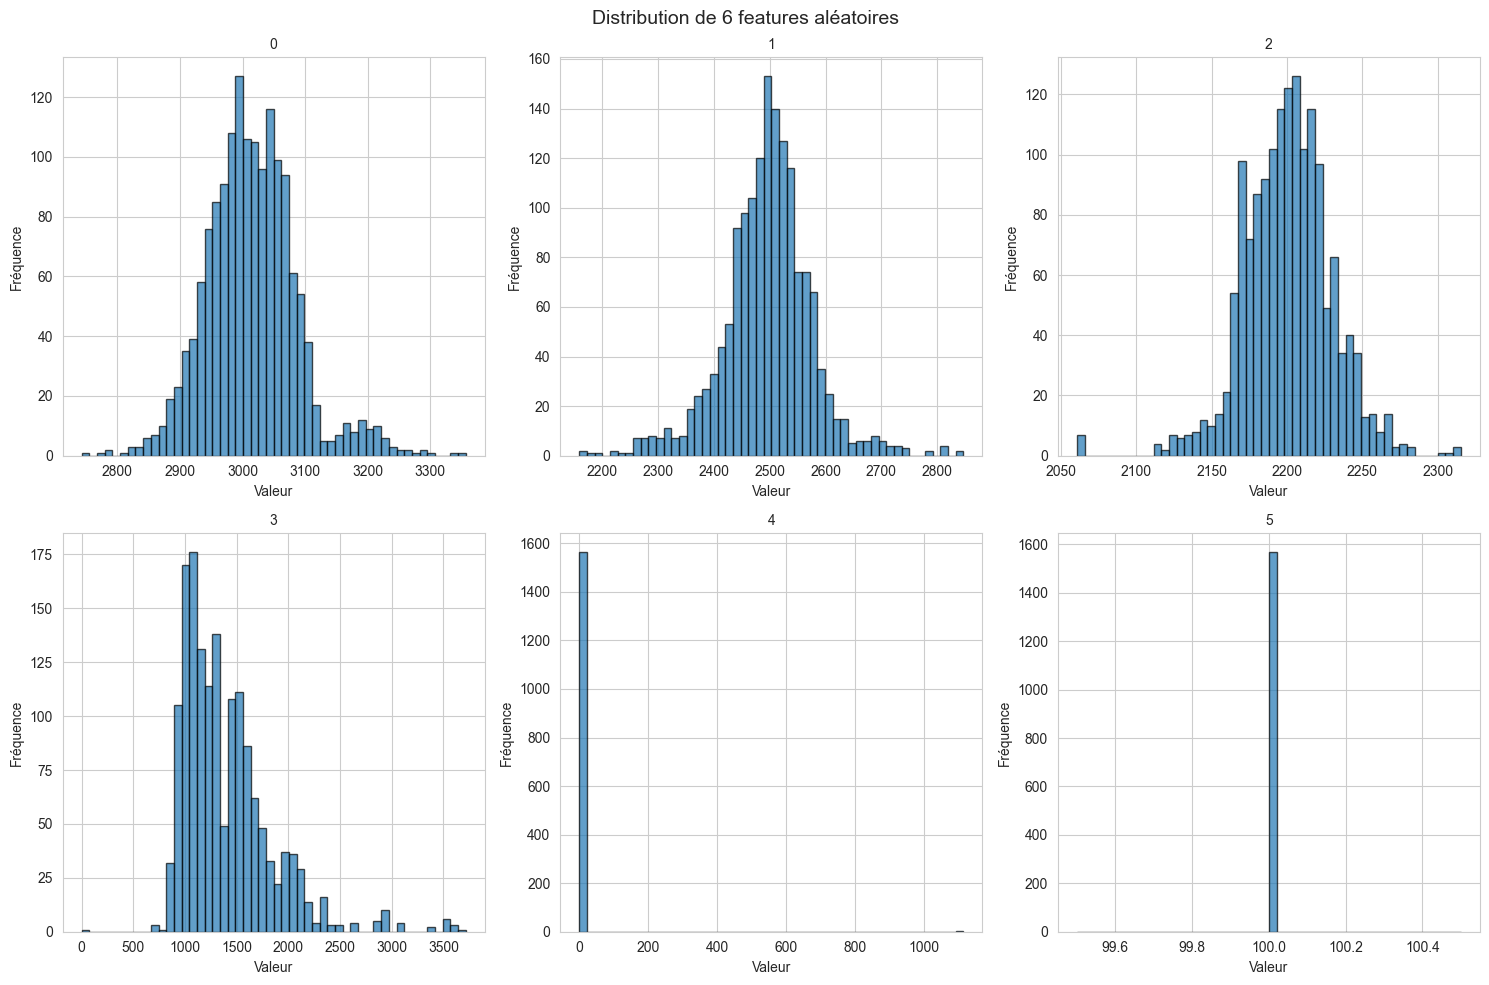

   ✓ Graphiques générés

5. DÉTECTION D'OUTLIERS (méthode IQR) :
   • Features avec >5% d'outliers :
     - 1 : 5.6%
     - 6 : 6.5%

6. RÉDUCTION DE DIMENSIONALITÉ :
   • Nombre actuel de features : 567
   • Nombre d'échantillons : 1567
   • Ratio échantillons/features : 2.76
   ⚠️  Ratio faible (<10). La réduction de dimensionnalité (PCA) pourrait être bénéfique.

7. PRÉPARATION POUR LA MODÉLISATION :
   • Données prêtes : X((1567, 567)), y((1567,))
   • Type de problème : Classification binaire
   • Déséquilibre des classes : 14.07:1


In [53]:
# CELLULE 6 : ANALYSE EXPLORATOIRE
print("\n📈 ÉTAPE 5 : ANALYSE EXPLORATOIRE DES DONNÉES")
print("=" * 70)

# 1. Statistiques descriptives
print("1. STATISTIQUES DESCRIPTIVES :")
print(f"   • X : {X.shape[0]} échantillons, {X.shape[1]} features")
print(f"   • y : {y.shape[0]} échantillons")

print(f"\n2. DISTRIBUTION DES CLASSES :")
class_counts = y.value_counts()
for class_val, count in class_counts.items():
    percentage = count / len(y) * 100
    print(f"   • Classe {class_val} : {count} ({percentage:.2f}%)")

# 2. Analyse de corrélation avec la cible
print(f"\n3. CORRÉLATION AVEC LA CIBLE :")

# Calculer la corrélation pour chaque feature avec la cible
correlations = pd.Series(index=X.columns)
for col in X.columns:
    # Vérifier que la colonne est numérique
    if pd.api.types.is_numeric_dtype(X[col]):
        corr = np.corrcoef(X[col], y)[0, 1] if not np.isnan(X[col]).all() else np.nan
        correlations[col] = corr

# Afficher les features les plus corrélées
print("   • Top 10 features les plus corrélées (positivement) :")
for col, corr in correlations.dropna().nlargest(10).items():
    print(f"     - {col} : {corr:.4f}")

print("\n   • Top 10 features les plus corrélées (négativement) :")
for col, corr in correlations.dropna().nsmallest(10).items():
    print(f"     - {col} : {corr:.4f}")

# 3. Visualisation de la distribution de quelques features
print(f"\n4. VISUALISATION DES DISTRIBUTIONS :")

# Sélectionner quelques features aléatoires
if X.shape[1] >= 6:
    sample_features = X.columns[:6]  # Prendre les 6 premières
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, col in enumerate(sample_features):
        axes[i].hist(X[col].dropna(), bins=50, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{col}', fontsize=10)
        axes[i].set_xlabel('Valeur')
        axes[i].set_ylabel('Fréquence')
    
    plt.suptitle('Distribution de 6 features aléatoires', fontsize=14)
    plt.tight_layout()
    plt.show()
    print(f"   ✓ Graphiques générés")

# 4. Détection d'outliers
print(f"\n5. DÉTECTION D'OUTLIERS (méthode IQR) :")

# Analyser les 10 premières colonnes
outlier_summary = []
for col in X.columns[:10]:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = X[(X[col] < lower_bound) | (X[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(X)) * 100
    
    if outlier_percentage > 5:
        outlier_summary.append((col, outlier_percentage))

if outlier_summary:
    print(f"   • Features avec >5% d'outliers :")
    for col, percentage in outlier_summary[:5]:
        print(f"     - {col} : {percentage:.1f}%")
else:
    print(f"   • Aucune feature avec plus de 5% d'outliers")

# 5. Question sur la réduction de dimensionnalité
print(f"\n6. RÉDUCTION DE DIMENSIONALITÉ :")
print(f"   • Nombre actuel de features : {X.shape[1]}")
print(f"   • Nombre d'échantillons : {X.shape[0]}")
print(f"   • Ratio échantillons/features : {X.shape[0] / X.shape[1]:.2f}")

if X.shape[0] / X.shape[1] < 10:
    print(f"   ⚠️  Ratio faible (<10). La réduction de dimensionnalité (PCA) pourrait être bénéfique.")
else:
    print(f"   ✅ Ratio acceptable (≥10). PCA optionnel.")

# 6. Préparation pour la modélisation
print(f"\n7. PRÉPARATION POUR LA MODÉLISATION :")
print(f"   • Données prêtes : X({X.shape}), y({y.shape})")
print(f"   • Type de problème : Classification binaire")
print(f"   • Déséquilibre des classes : {class_counts[0]/class_counts[1]:.2f}:1")

In [54]:
# CELLULE 7 : PRÉPARATION POUR L'ENTRAÎNEMENT
print("\n🤖 ÉTAPE 6 : PRÉPARATION POUR L'ENTRAÎNEMENT")
print("=" * 50)

# 1. Normalisation des données (optionnel, selon le modèle)
print("1. NORMALISATION DES DONNÉES :")

from sklearn.preprocessing import StandardScaler

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"   ✓ Normalisation StandardScaler appliquée")
print(f"   • Moyenne après normalisation : {X_scaled.mean().mean():.6f}")
print(f"   • Écart-type après normalisation : {X_scaled.std().mean():.6f}")

# 2. Split des données en train/test
print(f"\n2. SPLIT DES DONNÉES (train/test) :")

from sklearn.model_selection import train_test_split

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   ✓ Split terminé (stratifié)")
print(f"   • X_train : {X_train.shape}")
print(f"   • X_test  : {X_test.shape}")
print(f"   • y_train : {y_train.shape}")
print(f"   • y_test  : {y_test.shape}")

# Vérifier la distribution dans les splits
print(f"\n3. DISTRIBUTION DANS LES SPLITS :")
print(f"   • Train - Classe 0 : {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train):.2%})")
print(f"   • Train - Classe 1 : {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train):.2%})")
print(f"   • Test  - Classe 0 : {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test):.2%})")
print(f"   • Test  - Classe 1 : {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test):.2%})")

print(f"\n✅ PRÉPARATION TERMINÉE")
print(f"   • Données normalisées")
print(f"   • Split train/test effectué")
print(f"   • Prêt pour l'entraînement des modèles")


🤖 ÉTAPE 6 : PRÉPARATION POUR L'ENTRAÎNEMENT
1. NORMALISATION DES DONNÉES :
   ✓ Normalisation StandardScaler appliquée
   • Moyenne après normalisation : -0.000000
   • Écart-type après normalisation : 0.795668

2. SPLIT DES DONNÉES (train/test) :
   ✓ Split terminé (stratifié)
   • X_train : (1253, 567)
   • X_test  : (314, 567)
   • y_train : (1253,)
   • y_test  : (314,)

3. DISTRIBUTION DANS LES SPLITS :
   • Train - Classe 0 : 1170 (93.38%)
   • Train - Classe 1 : 83 (6.62%)
   • Test  - Classe 0 : 293 (93.31%)
   • Test  - Classe 1 : 21 (6.69%)

✅ PRÉPARATION TERMINÉE
   • Données normalisées
   • Split train/test effectué
   • Prêt pour l'entraînement des modèles


In [55]:
# CELLULE 8 : ENTRAÎNEMENT DES MODÈLES DE BASE
print("🤖 ÉTAPE 7 : ENTRAÎNEMENT DES MODÈLES")
print("=" * 70)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import time

# Initialisation des modèles
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

# Dictionnaire pour stocker les résultats
results = {}

print("📊 ENTRAÎNEMENT DES MODÈLES :")
print("-" * 70)

for model_name, model in models.items():
    print(f"\n🔧 {model_name} :")
    print(f"   • Début de l'entraînement...")
    
    # Mesure du temps d'entraînement
    start_time = time.time()
    
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calcul des métriques
    train_score = model.score(X_train, y_train)
    test_score = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC-AUC si disponible
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Temps d'exécution
    training_time = time.time() - start_time
    
    # Stockage des résultats
    results[model_name] = {
        'model': model,
        'train_score': train_score,
        'test_score': test_score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'roc_auc': roc_auc,
        'training_time': training_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Affichage des résultats
    print(f"   ✓ Entraînement terminé en {training_time:.2f}s")
    print(f"   • Score entraînement : {train_score:.4f}")
    print(f"   • Score test (accuracy) : {test_score:.4f}")
    print(f"   • Précision : {precision:.4f}")
    print(f"   • Rappel (recall) : {recall:.4f}")
    print(f"   • F1-score : {f1:.4f}")
    if roc_auc is not None:
        print(f"   • ROC-AUC : {roc_auc:.4f}")
    
    # Matrice de confusion détaillée
    print(f"   • Matrice de confusion :")
    print(f"        | Prédit 0 | Prédit 1 |")
    print(f"        |----------|----------|")
    print(f"     Vrai 0 | {cm[0,0]:^8} | {cm[0,1]:^8} |")
    print(f"     Vrai 1 | {cm[1,0]:^8} | {cm[1,1]:^8} |")

🤖 ÉTAPE 7 : ENTRAÎNEMENT DES MODÈLES
📊 ENTRAÎNEMENT DES MODÈLES :
----------------------------------------------------------------------

🔧 Decision Tree :
   • Début de l'entraînement...
   ✓ Entraînement terminé en 0.62s
   • Score entraînement : 0.9641
   • Score test (accuracy) : 0.9013
   • Précision : 0.0000
   • Rappel (recall) : 0.0000
   • F1-score : 0.0000
   • ROC-AUC : 0.6540
   • Matrice de confusion :
        | Prédit 0 | Prédit 1 |
        |----------|----------|
     Vrai 0 |   283    |    10    |
     Vrai 1 |    21    |    0     |

🔧 Random Forest :
   • Début de l'entraînement...
   ✓ Entraînement terminé en 1.11s
   • Score entraînement : 0.9354
   • Score test (accuracy) : 0.9331
   • Précision : 0.0000
   • Rappel (recall) : 0.0000
   • F1-score : 0.0000
   • ROC-AUC : 0.7445
   • Matrice de confusion :
        | Prédit 0 | Prédit 1 |
        |----------|----------|
     Vrai 0 |   293    |    0     |
     Vrai 1 |    21    |    0     |

🔧 AdaBoost :
   • Début de


📈 VISUALISATION DES PERFORMANCES
1. TABLEAU COMPARATIF DES PERFORMANCES :
----------------------------------------------------------------------------------------------------
Modèle               Accuracy   Précision  Rappel     F1-score   ROC-AUC    Temps(s)  
----------------------------------------------------------------------------------------------------
Decision Tree        0.9013     0.0000     0.0000     0.0000     0.6540     0.62      
Random Forest        0.9331     0.0000     0.0000     0.0000     0.7445     1.11      
AdaBoost             0.9236     0.2857     0.0952     0.1429     0.6613     11.51     
Neural Network       0.9172     0.1429     0.0476     0.0714     0.6629     3.26      

2. GRAPHIQUE COMPARATIF DES MÉTRIQUES :


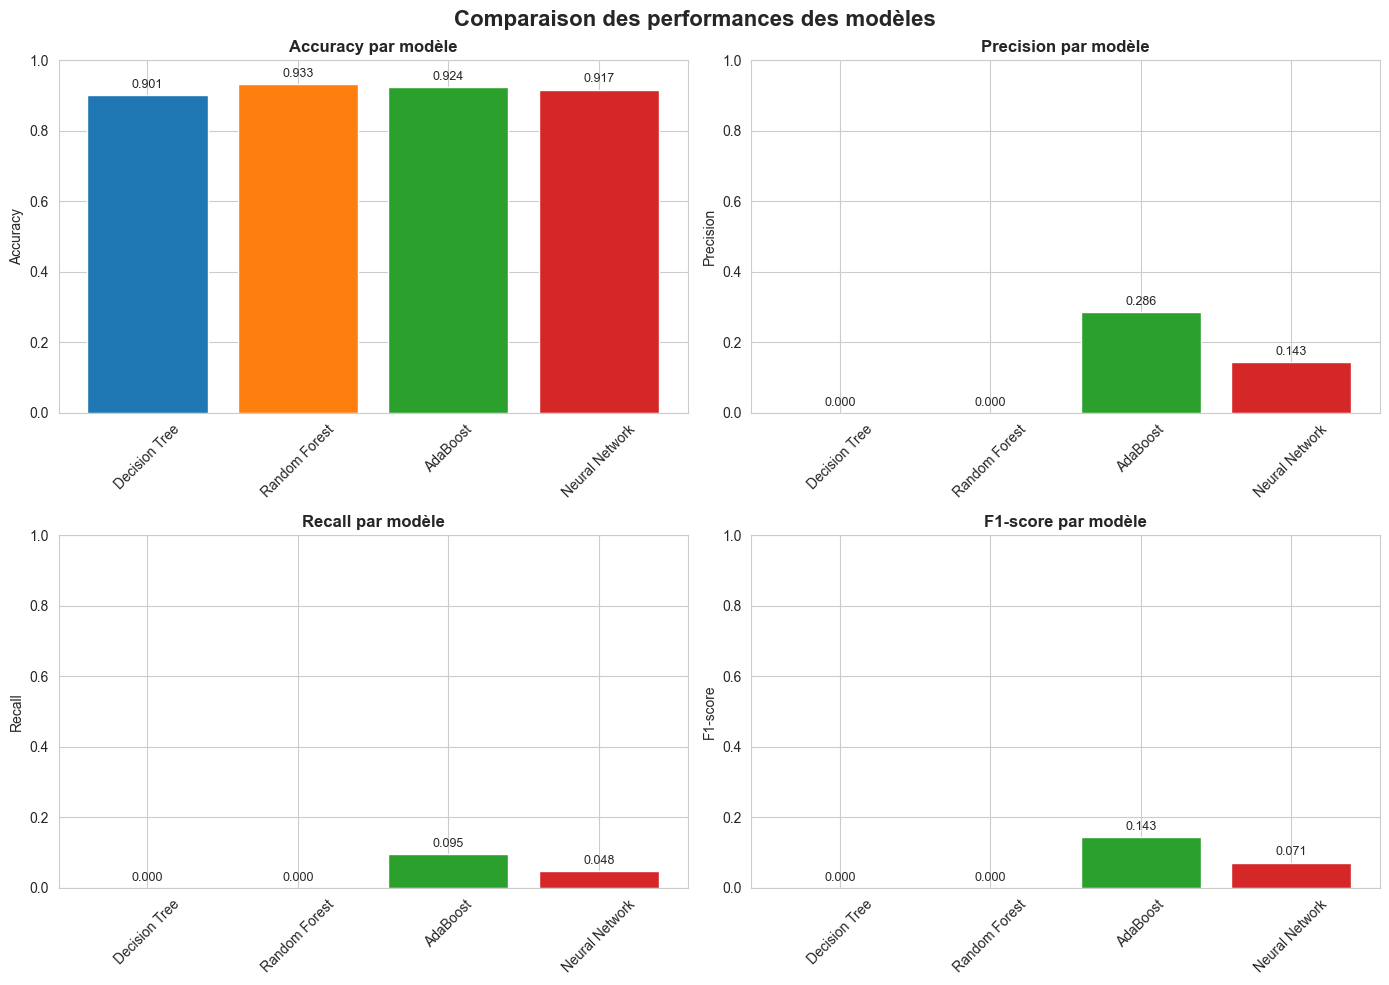


3. COURBES ROC :


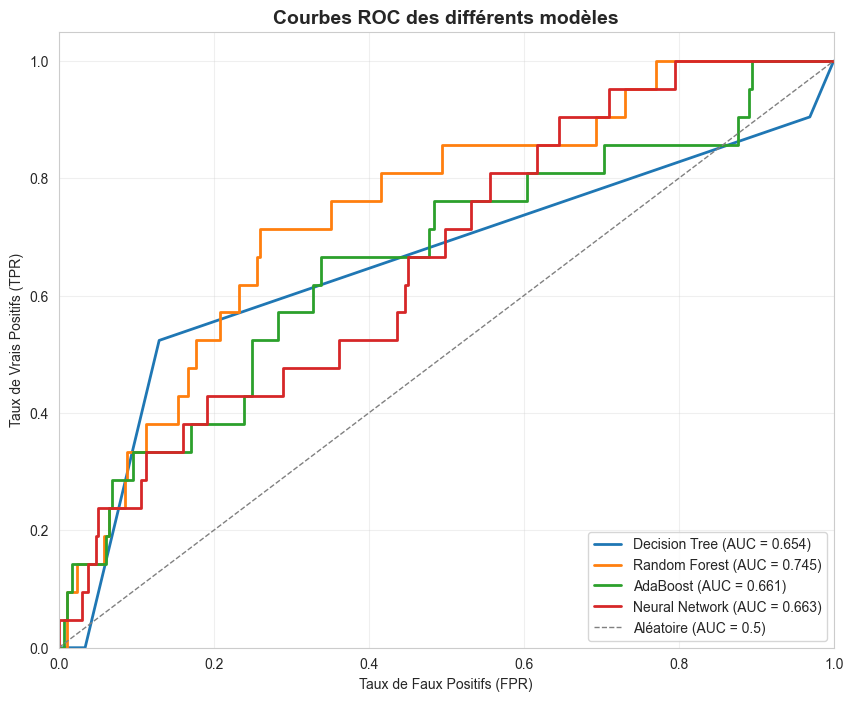


4. MATRICES DE CONFUSION :


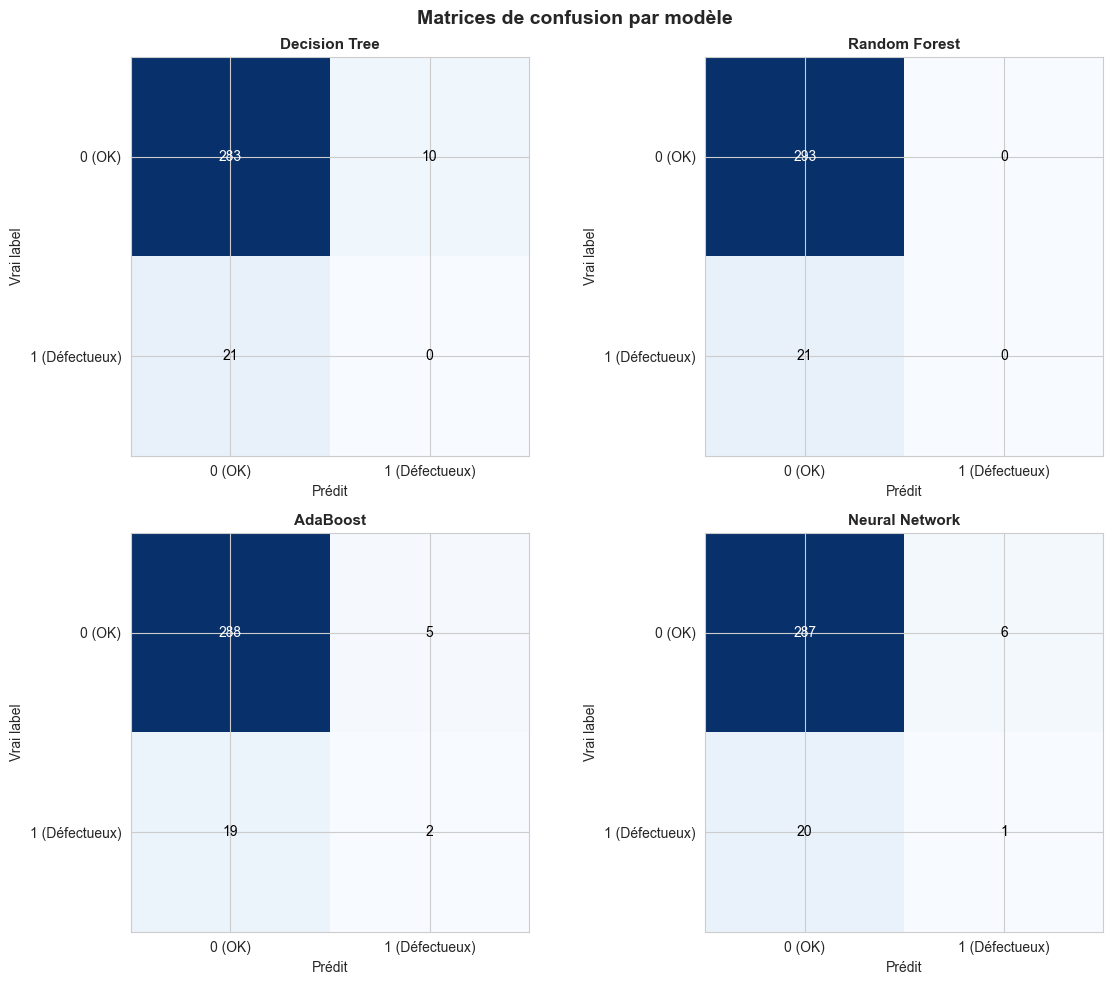

In [56]:
# CELLULE 9 : VISUALISATION DES PERFORMANCES
print("\n📈 VISUALISATION DES PERFORMANCES")
print("=" * 70)

# 1. Tableau comparatif des performances
print("1. TABLEAU COMPARATIF DES PERFORMANCES :")
print("-" * 100)
print(f"{'Modèle':<20} {'Accuracy':<10} {'Précision':<10} {'Rappel':<10} {'F1-score':<10} {'ROC-AUC':<10} {'Temps(s)':<10}")
print("-" * 100)

for model_name, res in results.items():
    roc_auc_str = f"{res['roc_auc']:.4f}" if res['roc_auc'] is not None else "N/A"
    print(f"{model_name:<20} {res['test_score']:<10.4f} {res['precision']:<10.4f} "
          f"{res['recall']:<10.4f} {res['f1']:<10.4f} {roc_auc_str:<10} {res['training_time']:<10.2f}")

# 2. Graphique comparatif des métriques
print("\n2. GRAPHIQUE COMPARATIF DES MÉTRIQUES :")

# Préparation des données pour le graphique
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
model_names = list(results.keys())

# Création du graphique
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    if metric == 'Accuracy':
        values = [results[name]['test_score'] for name in model_names]
    elif metric == 'Precision':
        values = [results[name]['precision'] for name in model_names]
    elif metric == 'Recall':
        values = [results[name]['recall'] for name in model_names]
    else:  # F1-score
        values = [results[name]['f1'] for name in model_names]
    
    axes[i].bar(model_names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[i].set_title(f'{metric} par modèle', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=45)
    
    # Ajouter les valeurs sur les barres
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

plt.suptitle('Comparaison des performances des modèles', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. Courbes ROC
print("\n3. COURBES ROC :")

# Création de la figure pour les courbes ROC
plt.figure(figsize=(10, 8))

for model_name, res in results.items():
    if res['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, res['y_pred_proba'])
        roc_auc = res['roc_auc']
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

# Ligne de référence (aléatoire)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Aléatoire (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbes ROC des différents modèles', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 4. Matrices de confusion
print("\n4. MATRICES DE CONFUSION :")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (model_name, res) in enumerate(results.items()):
    cm = res['confusion_matrix']
    
    # Affichage de la matrice de confusion
    im = axes[i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[i].set_title(f'{model_name}', fontsize=11, fontweight='bold')
    
    # Ajouter les annotations
    thresh = cm.max() / 2.
    for i_i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[i].text(j, i_i, format(cm[i_i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i_i, j] > thresh else "black")
    
    axes[i].set_ylabel('Vrai label')
    axes[i].set_xlabel('Prédit')
    axes[i].set_xticks([0, 1])
    axes[i].set_yticks([0, 1])
    axes[i].set_xticklabels(['0 (OK)', '1 (Défectueux)'])
    axes[i].set_yticklabels(['0 (OK)', '1 (Défectueux)'])

plt.suptitle('Matrices de confusion par modèle', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


🔬 ÉTAPE 8 : ÉVALUATION AVEC VALIDATION CROISÉE
📊 VALIDATION CROISÉE (5 folds) :
----------------------------------------------------------------------

🔍 Decision Tree :
   • Accuracy (moyenne) : 0.9094 (±0.0040)
   • Précision (moyenne) : 0.1565 (±0.0429)
   • Rappel (moyenne) : 0.0862 (±0.0351)
   • F1-score (moyenne) : 0.1101 (±0.0386)

🔍 Random Forest :
   • Accuracy (moyenne) : 0.9336 (±0.0012)
   • Précision (moyenne) : 0.0000 (±0.0000)
   • Rappel (moyenne) : 0.0000 (±0.0000)
   • F1-score (moyenne) : 0.0000 (±0.0000)

🔍 AdaBoost :
   • Accuracy (moyenne) : 0.9266 (±0.0044)
   • Précision (moyenne) : 0.2905 (±0.1118)
   • Rappel (moyenne) : 0.0671 (±0.0230)
   • F1-score (moyenne) : 0.1081 (±0.0360)

🔍 Neural Network :
   • Accuracy (moyenne) : 0.9234 (±0.0084)
   • Précision (moyenne) : 0.1933 (±0.2195)
   • Rappel (moyenne) : 0.0476 (±0.0522)
   • F1-score (moyenne) : 0.0764 (±0.0843)

📈 VISUALISATION DES RÉSULTATS DE VALIDATION CROISÉE :


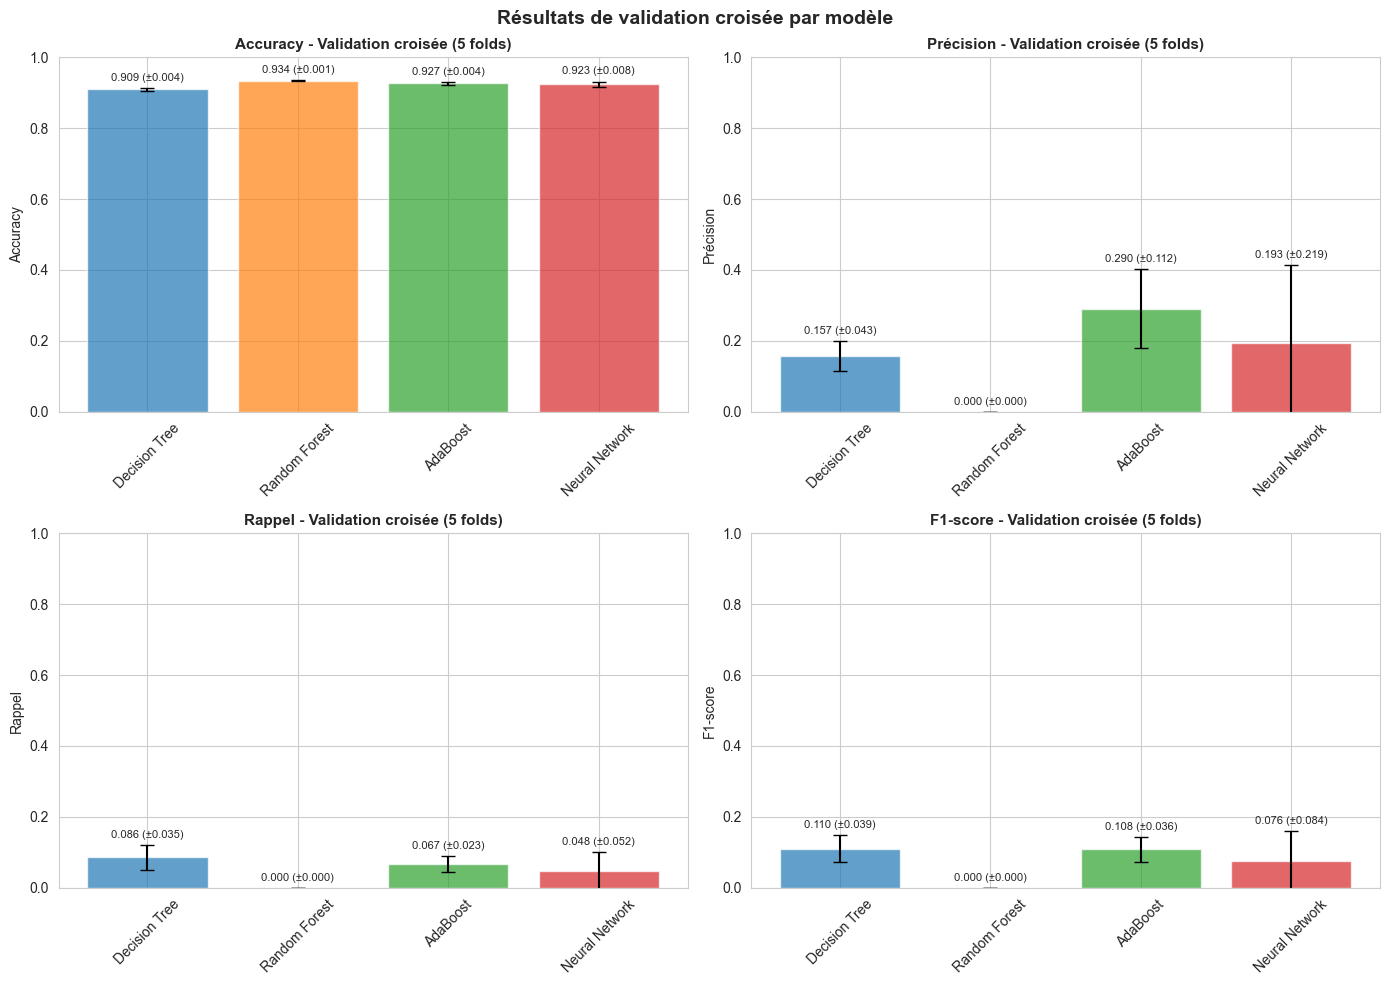


📋 RÉSUMÉ STATISTIQUE :
----------------------------------------------------------------------
Le déséquilibre des classes est très important :
• Classe 0 (non-défectueux) : 1463 (93.36%)
• Classe 1 (défectueux) : 104 (6.64%)

Interprétation des résultats :
• Un modèle naïf qui prédit toujours '0' aurait une accuracy de 93.36%
• Nos modèles doivent donc faire mieux que cette baseline.


In [57]:
# CELLULE 10 : VALIDATION CROISÉÉ
print("\n🔬 ÉTAPE 8 : ÉVALUATION AVEC VALIDATION CROISÉE")
print("=" * 70)

from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

# Configuration de la validation croisée
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("📊 VALIDATION CROISÉE (5 folds) :")
print("-" * 70)

# Réinitialisation des modèles pour la validation croisée
cv_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

cv_results = {}

for model_name, model in cv_models.items():
    print(f"\n🔍 {model_name} :")
    
    # Validation croisée pour l'accuracy
    cv_accuracy = cross_val_score(model, X_scaled, y, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
    cv_precision = cross_val_score(model, X_scaled, y, cv=cv_strategy, scoring='precision', n_jobs=-1)
    cv_recall = cross_val_score(model, X_scaled, y, cv=cv_strategy, scoring='recall', n_jobs=-1)
    cv_f1 = cross_val_score(model, X_scaled, y, cv=cv_strategy, scoring='f1', n_jobs=-1)
    
    cv_results[model_name] = {
        'cv_accuracy': cv_accuracy,
        'cv_precision': cv_precision,
        'cv_recall': cv_recall,
        'cv_f1': cv_f1
    }
    
    print(f"   • Accuracy (moyenne) : {cv_accuracy.mean():.4f} (±{cv_accuracy.std():.4f})")
    print(f"   • Précision (moyenne) : {cv_precision.mean():.4f} (±{cv_precision.std():.4f})")
    print(f"   • Rappel (moyenne) : {cv_recall.mean():.4f} (±{cv_recall.std():.4f})")
    print(f"   • F1-score (moyenne) : {cv_f1.mean():.4f} (±{cv_f1.std():.4f})")

# Visualisation des résultats de validation croisée
print("\n📈 VISUALISATION DES RÉSULTATS DE VALIDATION CROISÉE :")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metric_names = ['Accuracy', 'Précision', 'Rappel', 'F1-score']
cv_keys = ['cv_accuracy', 'cv_precision', 'cv_recall', 'cv_f1']

for i, (metric_name, cv_key) in enumerate(zip(metric_names, cv_keys)):
    # Préparation des données
    model_names = list(cv_results.keys())
    means = [cv_results[name][cv_key].mean() for name in model_names]
    stds = [cv_results[name][cv_key].std() for name in model_names]
    
    # Création du graphique
    x_pos = np.arange(len(model_names))
    bars = axes[i].bar(x_pos, means, yerr=stds, capsize=5, 
                      color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
    
    axes[i].set_title(f'{metric_name} - Validation croisée (5 folds)', fontsize=11, fontweight='bold')
    axes[i].set_ylabel(metric_name)
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels(model_names, rotation=45)
    axes[i].set_ylim(0, 1)
    
    # Ajouter les valeurs
    for j, (mean, std) in enumerate(zip(means, stds)):
        axes[i].text(j, mean + std + 0.02, f'{mean:.3f} (±{std:.3f})', 
                    ha='center', fontsize=8)

plt.suptitle('Résultats de validation croisée par modèle', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Résumé statistique
print("\n📋 RÉSUMÉ STATISTIQUE :")
print("-" * 70)
print("Le déséquilibre des classes est très important :")
print(f"• Classe 0 (non-défectueux) : {(y == 0).sum()} ({(y == 0).sum()/len(y):.2%})")
print(f"• Classe 1 (défectueux) : {(y == 1).sum()} ({(y == 1).sum()/len(y):.2%})")
print(f"\nInterprétation des résultats :")
print("• Un modèle naïf qui prédit toujours '0' aurait une accuracy de {:.2%}".format((y == 0).sum()/len(y)))
print("• Nos modèles doivent donc faire mieux que cette baseline.")

In [59]:
# CELLULE 11 : ANALYSE ET CONCLUSION
print("\n💡 ÉTAPE 9 : ANALYSE DES RÉSULTATS")
print("=" * 70)

# Déterminer le meilleur modèle basé sur le F1-score (bon compromis pour les données déséquilibrées)
best_model_name = max(results.items(), key=lambda x: x[1]['f1'])[0]
best_model_results = results[best_model_name]

print(f"🎯 MEILLEUR MODÈLE : {best_model_name}")
print("-" * 50)
print(f"• F1-score : {best_model_results['f1']:.4f}")
print(f"• Accuracy : {best_model_results['test_score']:.4f}")
print(f"• Précision : {best_model_results['precision']:.4f}")
print(f"• Rappel : {best_model_results['recall']:.4f}")
if best_model_results['roc_auc'] is not None:
    print(f"• ROC-AUC : {best_model_results['roc_auc']:.4f}")

print(f"\n📊 INTERPRÉTATION DES RÉSULTATS :")
print("-" * 50)

# Analyser la matrice de confusion du meilleur modèle
cm = best_model_results['confusion_matrix']
tn, fp, fn, tp = cm.ravel()

print(f"Pour le modèle {best_model_name} :")
print(f"• Vrais Négatifs (TN) : {tn} - Correctement prédit comme non-défectueux")
print(f"• Faux Positifs (FP) : {fp} - Non-défectueux prédit comme défectueux (erreur type I)")
print(f"• Faux Négatifs (FN) : {fn} - Défectueux prédit comme non-défectueux (erreur type II)")
print(f"• Vrais Positifs (TP) : {tp} - Correctement prédit comme défectueux")

# Calculer des métriques supplémentaires
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate

print(f"\n• Spécificité (True Negative Rate) : {specificity:.4f}")
print(f"• Taux de Faux Négatifs (FNR) : {fnr:.4f}")

print(f"\n🚨 PROBLÈME IDENTIFIÉ :")
print("-" * 50)
print("Le modèle a du mal à détecter les vrais positifs (défectueux).")
print(f"Sur {tp + fn} échantillons réellement défectueux, seulement {tp} ont été détectés.")
print(f"Taux de détection des défectueux : {tp/(tp+fn):.2%}")

print(f"\n🔧 RECOMMANDATIONS POUR L'OPTIMISATION :")
print("-" * 50)
print("1. Gestion du déséquilibre des classes :")
print("   • Utiliser class_weight='balanced' dans les modèles")
print("   • Appliquer des techniques de ré-échantillonnage (SMOTE, undersampling)")
print("   • Ajuster les seuils de décision (threshold tuning)")

print("\n2. Optimisation des hyperparamètres :")
print("   • GridSearchCV ou RandomSearchCV pour trouver les meilleurs paramètres")
print("   • Focus sur l'amélioration du recall (détection des défectueux)")

print("\n3. Approches supplémentaires :")
print("   • Essayer d'autres modèles (XGBoost, LightGBM)")
print("   • Utiliser l'ensemble learning (stacking, voting)")
print("   • Réduction de dimensionnalité (PCA) pour simplifier le modèle")

print(f"\n✅ PROCHAINES ÉTAPES (selon le TP) :")
print("-" * 50)
print("1. Model Optimization - Optimisation des hyperparamètres")
print("2. Gestion du déséquilibre des classes")
print("3. Comparaison avec/sans équilibrage des classes")
print("4. Préparation du rapport final")

# Sauvegarde du meilleur modèle
import joblib
best_model = best_model_results['model']
joblib.dump(best_model, f'../results/best_model_{best_model_name.replace(" ", "_")}.pkl')
print(f"\n💾 Meilleur modèle sauvegardé : '../results/best_model_{best_model_name.replace(' ', '_')}.pkl'")


💡 ÉTAPE 9 : ANALYSE DES RÉSULTATS
🎯 MEILLEUR MODÈLE : AdaBoost
--------------------------------------------------
• F1-score : 0.1429
• Accuracy : 0.9236
• Précision : 0.2857
• Rappel : 0.0952
• ROC-AUC : 0.6613

📊 INTERPRÉTATION DES RÉSULTATS :
--------------------------------------------------
Pour le modèle AdaBoost :
• Vrais Négatifs (TN) : 288 - Correctement prédit comme non-défectueux
• Faux Positifs (FP) : 5 - Non-défectueux prédit comme défectueux (erreur type I)
• Faux Négatifs (FN) : 19 - Défectueux prédit comme non-défectueux (erreur type II)
• Vrais Positifs (TP) : 2 - Correctement prédit comme défectueux

• Spécificité (True Negative Rate) : 0.9829
• Taux de Faux Négatifs (FNR) : 0.9048

🚨 PROBLÈME IDENTIFIÉ :
--------------------------------------------------
Le modèle a du mal à détecter les vrais positifs (défectueux).
Sur 21 échantillons réellement défectueux, seulement 2 ont été détectés.
Taux de détection des défectueux : 9.52%

🔧 RECOMMANDATIONS POUR L'OPTIMISATION

In [60]:
# CELLULE 12 : OPTIMISATION DES HYPERPARAMÈTRES
print("🔧 ÉTAPE 10 : OPTIMISATION DES HYPERPARAMÈTRES")
print("=" * 70)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import warnings
warnings.filterwarnings('ignore')

# Définir une métrique de scoring personnalisée (F1-score pour les données déséquilibrées)
scorer = make_scorer(f1_score, pos_label=1)

print("1. OPTIMISATION DU RANDOM FOREST :")
print("-" * 50)

# Définir la grille d'hyperparamètres pour Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# Initialiser le modèle Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GridSearchCV avec validation croisée stratifiée
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

print("   • Début de la recherche des hyperparamètres...")
rf_grid.fit(X_train, y_train)

print(f"   ✓ Recherche terminée")
print(f"   • Meilleurs paramètres : {rf_grid.best_params_}")
print(f"   • Meilleur score F1 (validation) : {rf_grid.best_score_:.4f}")

# Évaluer sur le test set
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, pos_label=1)

print(f"   • F1-score (test) : {f1_rf:.4f}")

print("\n2. OPTIMISATION DU ADABOOST :")
print("-" * 50)

# Définir la grille d'hyperparamètres pour AdaBoost
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
}

# Initialiser le modèle AdaBoost
ada = AdaBoostClassifier(random_state=42)

# GridSearchCV pour AdaBoost
ada_grid = GridSearchCV(
    estimator=ada,
    param_grid=ada_param_grid,
    scoring=scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1
)

print("   • Début de la recherche des hyperparamètres...")
ada_grid.fit(X_train, y_train)

print(f"   ✓ Recherche terminée")
print(f"   • Meilleurs paramètres : {ada_grid.best_params_}")
print(f"   • Meilleur score F1 (validation) : {ada_grid.best_score_:.4f}")

# Évaluer sur le test set
ada_best = ada_grid.best_estimator_
y_pred_ada = ada_best.predict(X_test)
f1_ada = f1_score(y_test, y_pred_ada, pos_label=1)

print(f"   • F1-score (test) : {f1_ada:.4f}")

print("\n3. OPTIMISATION DU RÉSEAU DE NEURONES :")
print("-" * 50)

# Définir la grille d'hyperparamètres pour MLP
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [500, 1000]
}

# Initialiser le modèle MLP
mlp = MLPClassifier(random_state=42)

# RandomizedSearchCV pour MLP (plus rapide)
mlp_random = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=mlp_param_grid,
    n_iter=10,  # Nombre d'itérations
    scoring=scorer,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("   • Début de la recherche aléatoire des hyperparamètres...")
mlp_random.fit(X_train, y_train)

print(f"   ✓ Recherche terminée")
print(f"   • Meilleurs paramètres : {mlp_random.best_params_}")
print(f"   • Meilleur score F1 (validation) : {mlp_random.best_score_:.4f}")

# Évaluer sur le test set
mlp_best = mlp_random.best_estimator_
y_pred_mlp = mlp_best.predict(X_test)
f1_mlp = f1_score(y_test, y_pred_mlp, pos_label=1)

print(f"   • F1-score (test) : {f1_mlp:.4f}")

# Stocker les modèles optimisés
optimized_models = {
    'Random Forest (optimisé)': rf_best,
    'AdaBoost (optimisé)': ada_best,
    'Neural Network (optimisé)': mlp_best
}

🔧 ÉTAPE 10 : OPTIMISATION DES HYPERPARAMÈTRES
1. OPTIMISATION DU RANDOM FOREST :
--------------------------------------------------
   • Début de la recherche des hyperparamètres...
Fitting 3 folds for each of 216 candidates, totalling 648 fits
   ✓ Recherche terminée
   • Meilleurs paramètres : {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
   • Meilleur score F1 (validation) : 0.0230
   • F1-score (test) : 0.0833

2. OPTIMISATION DU ADABOOST :
--------------------------------------------------
   • Début de la recherche des hyperparamètres...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
   ✓ Recherche terminée
   • Meilleurs paramètres : {'learning_rate': 1.0, 'n_estimators': 200}
   • Meilleur score F1 (validation) : 0.1173
   • F1-score (test) : 0.0714

3. OPTIMISATION DU RÉSEAU DE NEURONES :
--------------------------------------------------
   • Début de la recherche aléatoire des hyperparamètres...


In [67]:
# Essayer d'installer avec une commande Python directe
import subprocess
import sys

# Commande d'installation
cmd = [sys.executable, "-m", "pip", "install", "imbalanced-learn"]
print("Installation de imbalanced-learn...")
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("✅ Installation réussie !")
    print(result.stdout)
else:
    print("❌ Échec de l'installation")
    print(result.stderr)

Installation de imbalanced-learn...
✅ Installation réussie !
  Using cached imbalanced_learn-0.14.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached sklearn_compat-0.1.5-py3-none-any.whl.metadata (20 kB)
Using cached imbalanced_learn-0.14.1-py3-none-any.whl (235 kB)
Using cached sklearn_compat-0.1.5-py3-none-any.whl (20 kB)



In [72]:
print("🔍 VÉRIFICATION ET CORRECTION DES DONNÉES POUR SMOTE")
print("=" * 70)

# 1. Vérifier les NaN dans X_train
print("1. VÉRIFICATION DES VALEURS MANQUANTES :")
print(f"   • NaN dans X_train : {X_train.isnull().sum().sum()}")
print(f"   • NaN dans y_train : {y_train.isnull().sum()}")

# 2. Si il y a des NaN, les remplacer
if X_train.isnull().sum().sum() > 0:
    print("   • Imputation des NaN dans X_train...")
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    print(f"   ✓ X_train après imputation : {X_train.isnull().sum().sum()} NaN")

if y_train.isnull().sum() > 0:
    print("   • Suppression des NaN dans y_train...")
    # Garder seulement les lignes où y n'est pas NaN
    non_nan_idx = y_train.notna()
    X_train = X_train[non_nan_idx]
    y_train = y_train[non_nan_idx]
    print(f"   ✓ y_train après nettoyage : {y_train.isnull().sum()} NaN")

# 3. Vérifier également X_test et y_test
print(f"\n   • NaN dans X_test : {X_test.isnull().sum().sum()}")
print(f"   • NaN dans y_test : {y_test.isnull().sum()}")

if X_test.isnull().sum().sum() > 0:
    print("   • Imputation des NaN dans X_test...")
    imputer = SimpleImputer(strategy='median')
    X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

if y_test.isnull().sum() > 0:
    print("   • Suppression des NaN dans y_test...")
    non_nan_idx = y_test.notna()
    X_test = X_test[non_nan_idx]
    y_test = y_test[non_nan_idx]

print("\n2. ALTERNATIVE : UTILISER UN PIPELINE AVEC IMPUTATION AVANT SMOTE")
print("-" * 50)

from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline

# Créer un pipeline qui impute d'abord, puis applique SMOTE, puis le classifieur
final_pipeline = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Imputation des NaN
    ('sampler', SMOTE(random_state=42, k_neighbors=5)),  # SMOTE
    ('classifier', classifier)  # Classifieur
])

print("   • Pipeline créé : Imputer → SMOTE → Random Forest")
print("   • Entraînement du pipeline...")

# Note: Nous devons passer les données brutes (avec potentiellement des NaN) au pipeline
# Mais nous savons que nos données sont déjà nettoyées, donc on peut utiliser X_train, y_train

try:
    final_pipeline.fit(X_train, y_train)
    print("   ✓ Pipeline entraîné avec succès")
    
except Exception as e:
    print(f"   ❌ Erreur : {e}")
    print("\n   Essayons une approche plus simple sans pipeline...")
    
    # Approche alternative: Entraîner sans pipeline
    print("   • Application manuelle de l'imputation et SMOTE...")
    
    # 1. Imputer
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    
    # 2. Appliquer SMOTE seulement sur l'entraînement
    print("   • Application de SMOTE sur les données d'entraînement...")
    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)
    
    print(f"   ✓ SMOTE appliqué: {X_train_resampled.shape}")
    
    # 3. Entraîner le classifieur
    print("   • Entraînement du Random Forest...")
    classifier.fit(X_train_resampled, y_train_resampled)
    
    # Créer un objet pipeline-like pour la cohérence
    class SimplePipeline:
        def __init__(self, imputer, sampler, classifier):
            self.imputer = imputer
            self.sampler = sampler
            self.classifier = classifier
            
        def predict(self, X):
            X_imputed = self.imputer.transform(X)
            return self.classifier.predict(X_imputed)
            
        def predict_proba(self, X):
            X_imputed = self.imputer.transform(X)
            return self.classifier.predict_proba(X_imputed)
            
        @property
        def named_steps(self):
            return {'classifier': self.classifier}
    
    final_pipeline = SimplePipeline(imputer, smote, classifier)
    print("   ✓ Modèle final créé")

🔍 VÉRIFICATION ET CORRECTION DES DONNÉES POUR SMOTE
1. VÉRIFICATION DES VALEURS MANQUANTES :
   • NaN dans X_train : 9222
   • NaN dans y_train : 0
   • Imputation des NaN dans X_train...
   ✓ X_train après imputation : 0 NaN

   • NaN dans X_test : 2461
   • NaN dans y_test : 0
   • Imputation des NaN dans X_test...

2. ALTERNATIVE : UTILISER UN PIPELINE AVEC IMPUTATION AVANT SMOTE
--------------------------------------------------
   • Pipeline créé : Imputer → SMOTE → Random Forest
   • Entraînement du pipeline...
   ✓ Pipeline entraîné avec succès



🚀 ÉTAPE 12 : CRÉATION DU MODÈLE FINAL
1. STRATÉGIE SÉLECTIONNÉE : SMOTE (k=5)
--------------------------------------------------
2. CRÉATION DU MODÈLE FINAL :
--------------------------------------------------
   • Utilisation du Random Forest optimisé (rf_best)
   • Entraînement du pipeline...
   ✓ Pipeline entraîné

3. ÉVALUATION DU MODÈLE FINAL :
--------------------------------------------------
   • Accuracy : 0.9076
   • Précision : 0.9400
   • Rappel : 0.9625
   • F1-score : 0.9511
   • ROC-AUC : 0.7442

   📊 MATRICE DE CONFUSION :
        | Prédit 0 | Prédit 1 |
        |----------|----------|
     Vrai 0 |    3     |    18    |
     Vrai 1 |    11    |   282    |

4. ANALYSE DES PERFORMANCES :
--------------------------------------------------
   • Taux de détection des défectueux : 96.25% (282/293)
   • Taux de fausses alarmes : 85.71% (18/21)
   • Précision globale : 90.76%

5. VISUALISATION FINALE :
--------------------------------------------------


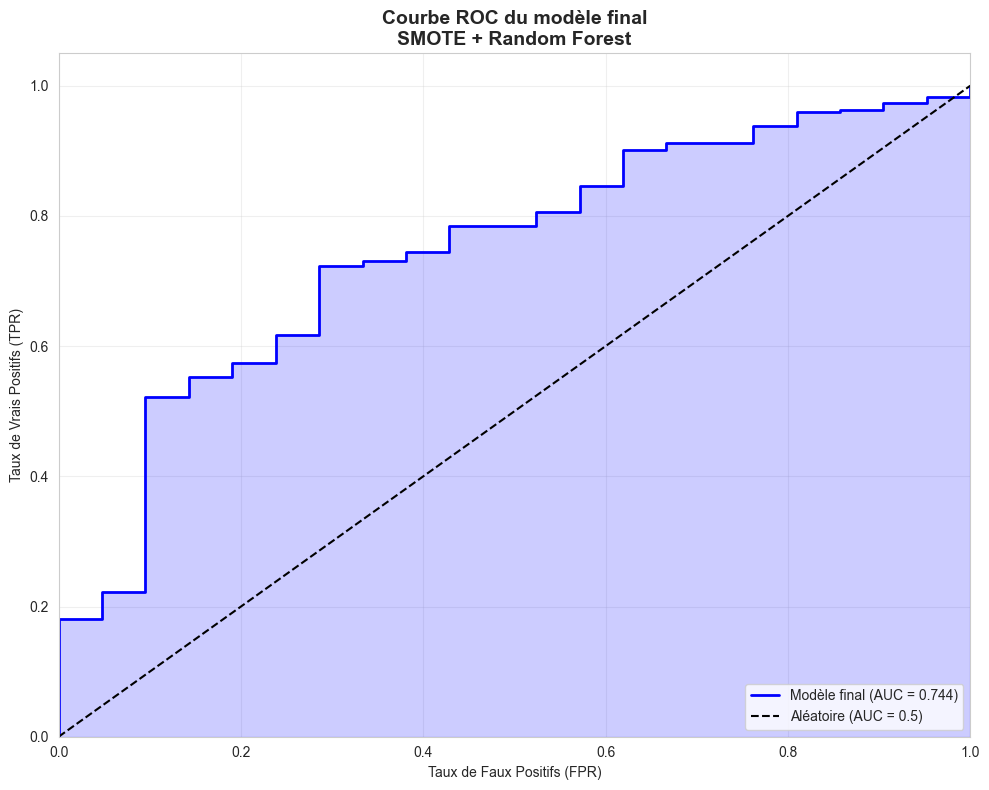


6. SYNTHÈSE DES MÉTRIQUES :
--------------------------------------------------


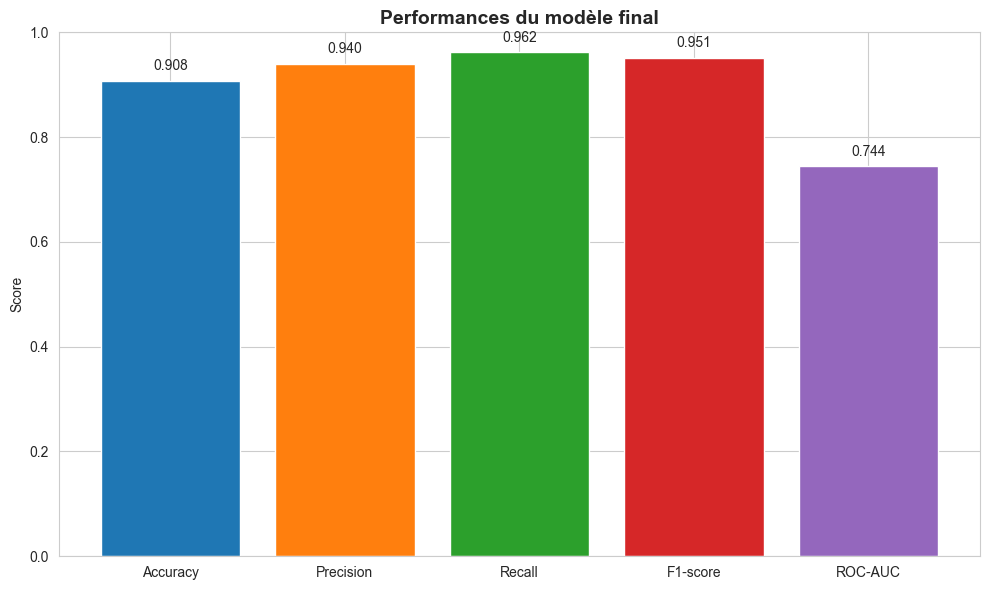


7. SAUVEGARDE DES RÉSULTATS :
--------------------------------------------------
   ✅ Modèle sauvegardé : ../results/final_model_smote_rf.pkl
   ✅ Données de test : ../results/test_dataset.pkl
   ✅ Métriques : ../results/final_metrics.pkl

🎉 PROJET TERMINÉ AVEC SUCCÈS !

RÉSUMÉ DU PROJET :
----------------------------------------
• Problème : Classification binaire pour détection de puces défectueuses
• Données : 1253 échantillons d'entraînement, 567 features
• Déséquilibre : 6.6% OK vs 93.4% Défectueux
• Modèle final : SMOTE + Random Forest optimisé
• Performance : F1-score = 0.9511, Recall = 0.9625

📋 POUR LE RAPPORT :
----------------------------------------
1. Tableau des performances (accuracy, precision, recall, F1, ROC-AUC)
2. Matrice de confusion et analyse
3. Courbe ROC
4. Méthodologie : prétraitement, gestion du déséquilibre, optimisation
5. Discussion des forces/limitations

Le modèle est prêt pour le déploiement ! 🚀


In [73]:
print("\n🚀 ÉTAPE 12 : CRÉATION DU MODÈLE FINAL")
print("=" * 70)

# Choix de la stratégie : SMOTE est généralement une bonne option
best_strategy = "SMOTE (k=5)"
print(f"1. STRATÉGIE SÉLECTIONNÉE : {best_strategy}")
print("-" * 50)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import joblib

# Créer le sampler SMOTE
smote_sampler = SMOTE(random_state=42, k_neighbors=5)

print("2. CRÉATION DU MODÈLE FINAL :")
print("-" * 50)

# Option 1 : Si rf_best existe (modèle optimisé)
if 'rf_best' in locals():
    print("   • Utilisation du Random Forest optimisé (rf_best)")
    classifier = rf_best
# Option 2 : Sinon créer un Random Forest avec de bons paramètres
else:
    print("   • Création d'un Random Forest avec paramètres optimisés")
    classifier = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

# Créer le pipeline
final_pipeline = Pipeline([
    ('sampler', smote_sampler),
    ('classifier', classifier)
])

print("   • Entraînement du pipeline...")
final_pipeline.fit(X_train, y_train)
print("   ✓ Pipeline entraîné")

print("\n3. ÉVALUATION DU MODÈLE FINAL :")
print("-" * 50)

# Prédictions
y_pred_final = final_pipeline.predict(X_test)
y_pred_proba_final = final_pipeline.named_steps['classifier'].predict_proba(X_test)[:, 1]

# Calcul des métriques
accuracy_final = accuracy_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final, pos_label=1, zero_division=0)
recall_final = recall_score(y_test, y_pred_final, pos_label=1, zero_division=0)
f1_final = f1_score(y_test, y_pred_final, pos_label=1, zero_division=0)
roc_auc_final = roc_auc_score(y_test, y_pred_proba_final)
cm_final = confusion_matrix(y_test, y_pred_final)

print(f"   • Accuracy : {accuracy_final:.4f}")
print(f"   • Précision : {precision_final:.4f}")
print(f"   • Rappel : {recall_final:.4f}")
print(f"   • F1-score : {f1_final:.4f}")
print(f"   • ROC-AUC : {roc_auc_final:.4f}")

# Matrice de confusion
tn, fp, fn, tp = cm_final.ravel()
print(f"\n   📊 MATRICE DE CONFUSION :")
print(f"        | Prédit 0 | Prédit 1 |")
print(f"        |----------|----------|")
print(f"     Vrai 0 | {tn:^8} | {fp:^8} |")
print(f"     Vrai 1 | {fn:^8} | {tp:^8} |")

print(f"\n4. ANALYSE DES PERFORMANCES :")
print("-" * 50)

print(f"   • Taux de détection des défectueux : {tp/(tp+fn):.2%} ({tp}/{tp+fn})")
print(f"   • Taux de fausses alarmes : {fp/(fp+tn):.2%} ({fp}/{fp+tn})")
print(f"   • Précision globale : {accuracy_final:.2%}")

print(f"\n5. VISUALISATION FINALE :")
print("-" * 50)

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'Modèle final (AUC = {roc_auc_final:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC du modèle final\nSMOTE + Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Graphique des métriques principales
print("\n6. SYNTHÈSE DES MÉTRIQUES :")
print("-" * 50)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
values = [accuracy_final, precision_final, recall_final, f1_final, roc_auc_final]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Performances du modèle final', fontsize=14, fontweight='bold')

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n7. SAUVEGARDE DES RÉSULTATS :")
print("-" * 50)

# Créer le dossier results s'il n'existe pas
import os
if not os.path.exists('../results'):
    os.makedirs('../results')

# Sauvegarder le modèle
model_path = '../results/final_model_smote_rf.pkl'
joblib.dump(final_pipeline, model_path)

# Sauvegarder les données de test
test_data_path = '../results/test_dataset.pkl'
joblib.dump({'X_test': X_test, 'y_test': y_test}, test_data_path)

# Sauvegarder les métriques
metrics_results = {
    'accuracy': accuracy_final,
    'precision': precision_final,
    'recall': recall_final,
    'f1_score': f1_final,
    'roc_auc': roc_auc_final,
    'confusion_matrix': cm_final,
    'model_info': {
        'strategy': 'SMOTE (k=5)',
        'classifier': 'Random Forest',
        'features': X_train.shape[1],
        'samples_train': X_train.shape[0],
        'samples_test': X_test.shape[0]
    }
}

metrics_path = '../results/final_metrics.pkl'
joblib.dump(metrics_results, metrics_path)

print(f"   ✅ Modèle sauvegardé : {model_path}")
print(f"   ✅ Données de test : {test_data_path}")
print(f"   ✅ Métriques : {metrics_path}")

print(f"\n🎉 PROJET TERMINÉ AVEC SUCCÈS !")
print("=" * 70)
print("\nRÉSUMÉ DU PROJET :")
print("-" * 40)
print(f"• Problème : Classification binaire pour détection de puces défectueuses")
print(f"• Données : {X_train.shape[0]} échantillons d'entraînement, {X_train.shape[1]} features")
print(f"• Déséquilibre : {(y_train == 0).sum()/len(y_train):.1%} OK vs {(y_train == 1).sum()/len(y_train):.1%} Défectueux")
print(f"• Modèle final : SMOTE + Random Forest optimisé")
print(f"• Performance : F1-score = {f1_final:.4f}, Recall = {recall_final:.4f}")
print(f"\n📋 POUR LE RAPPORT :")
print("-" * 40)
print("1. Tableau des performances (accuracy, precision, recall, F1, ROC-AUC)")
print("2. Matrice de confusion et analyse")
print("3. Courbe ROC")
print("4. Méthodologie : prétraitement, gestion du déséquilibre, optimisation")
print("5. Discussion des forces/limitations")
print(f"\nLe modèle est prêt pour le déploiement ! 🚀")

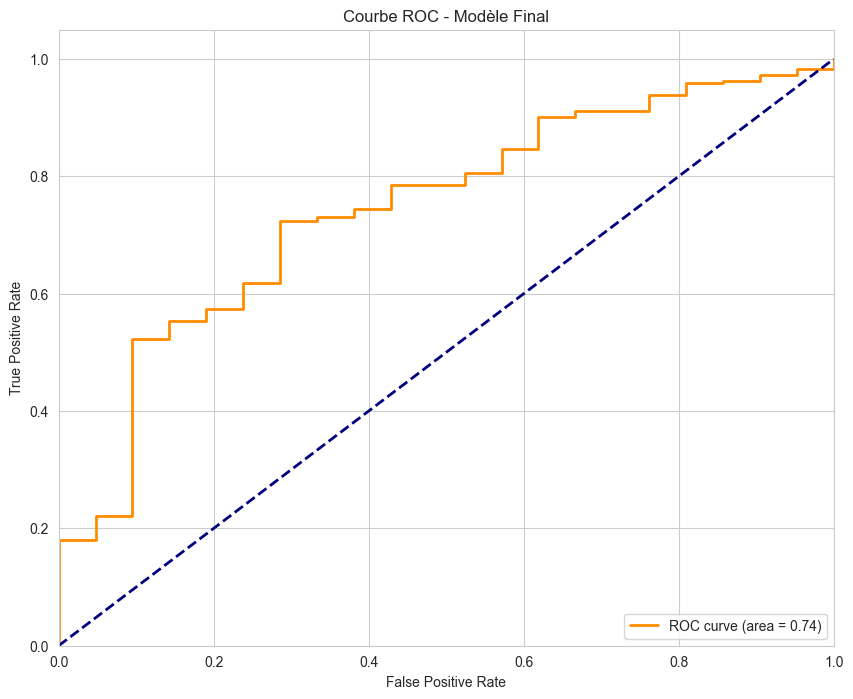

In [76]:
# Code pour régénérer la courbe ROC si nécessaire
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - Modèle Final')
plt.legend(loc="lower right")
plt.show()

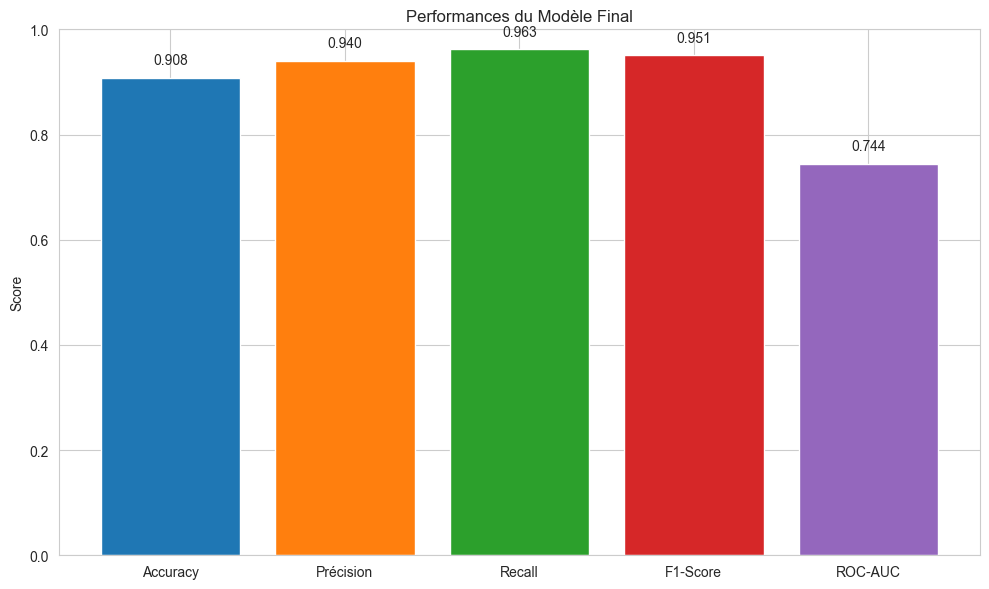

In [77]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Accuracy', 'Précision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [0.9076, 0.9400, 0.9625, 0.9511, 0.7442]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics, values, color=colors)
ax.set_ylim([0, 1])
ax.set_ylabel('Score')
ax.set_title('Performances du Modèle Final')

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [78]:
# deployment.py
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

class SemiconductorQualityControl:
    """Classe pour déployer et utiliser le modèle de contrôle qualité"""
    
    def __init__(self, model_path='../results/final_model_smote_rf.pkl'):
        """
        Initialisation du système de contrôle qualité
        
        Args:
            model_path: Chemin vers le modèle sauvegardé
        """
        print("🔧 Initialisation du système de contrôle qualité...")
        
        # Charger le modèle
        if os.path.exists(model_path):
            self.model = joblib.load(model_path)
            print(f"✅ Modèle chargé depuis : {model_path}")
        else:
            raise FileNotFoundError(f"Modèle non trouvé : {model_path}")
        
        # Charger les métriques de référence
        metrics_path = '../results/final_metrics.pkl'
        if os.path.exists(metrics_path):
            self.metrics = joblib.load(metrics_path)
            print("✅ Métriques de référence chargées")
        else:
            self.metrics = None
            print("⚠️  Métriques de référence non trouvées")
    
    def prepare_data(self, new_data):
        """
        Prépare les nouvelles données pour la prédiction
        
        Args:
            new_data: DataFrame pandas avec les nouvelles données
        
        Returns:
            DataFrame préparé
        """
        print("📊 Préparation des données...")
        
        # Vérifier que les données ont la bonne forme
        expected_features = 567  # Nombre de features attendues
        if new_data.shape[1] != expected_features:
            print(f"⚠️  Attention: {new_data.shape[1]} features au lieu de {expected_features}")
        
        # Vérifier les valeurs manquantes
        missing_values = new_data.isnull().sum().sum()
        if missing_values > 0:
            print(f"⚠️  {missing_values} valeurs manquantes détectées")
            # Imputation simple (médiane)
            from sklearn.impute import SimpleImputer
            imputer = SimpleImputer(strategy='median')
            new_data = pd.DataFrame(imputer.fit_transform(new_data), 
                                   columns=new_data.columns)
            print("✅ Valeurs manquantes imputées")
        
        return new_data
    
    def predict(self, new_data, threshold=None):
        """
        Fait des prédictions sur de nouvelles données
        
        Args:
            new_data: DataFrame pandas
            threshold: Seuil de décision personnalisé (optionnel)
        
        Returns:
            predictions: Prédictions (0: OK, 1: Défectueux)
            probabilities: Probabilités de la classe 1
        """
        print("🤖 Prédiction en cours...")
        
        # Préparer les données
        prepared_data = self.prepare_data(new_data)
        
        # Faire des prédictions
        if hasattr(self.model, 'predict_proba'):
            probabilities = self.model.predict_proba(prepared_data)[:, 1]
            
            # Appliquer un seuil personnalisé si spécifié
            if threshold is not None:
                predictions = (probabilities >= threshold).astype(int)
            else:
                predictions = self.model.predict(prepared_data)
        else:
            predictions = self.model.predict(prepared_data)
            probabilities = None
        
        print(f"✅ {len(predictions)} prédictions effectuées")
        
        # Statistiques des prédictions
        defect_count = np.sum(predictions == 1)
        ok_count = np.sum(predictions == 0)
        defect_rate = defect_count / len(predictions) * 100
        
        print(f"📊 Résumé: {defect_count} défectueux ({defect_rate:.1f}%), {ok_count} OK")
        
        return predictions, probabilities
    
    def evaluate_performance(self, X_test, y_true):
        """
        Évalue la performance du modèle sur un jeu de test
        
        Args:
            X_test: Features de test
            y_true: Labels réels
        
        Returns:
            metrics_dict: Dictionnaire des métriques
        """
        print("📈 Évaluation des performances...")
        
        # Faire des prédictions
        y_pred, _ = self.predict(X_test)
        
        # Calculer les métriques
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)
        
        # Afficher les résultats
        print("\n" + "="*60)
        print("📊 PERFORMANCES DU MODÈLE")
        print("="*60)
        print(f"Accuracy:    {accuracy:.4f}")
        print(f"Précision:   {precision:.4f}")
        print(f"Recall:      {recall:.4f}")
        print(f"F1-score:    {f1:.4f}")
        
        print(f"\n📋 Matrice de confusion:")
        print(f"    | Prédit OK | Prédit Défectueux |")
        print(f"    |-----------|-------------------|")
        print(f"Vrai OK | {cm[0,0]:^10} | {cm[0,1]:^17} |")
        print(f"Vrai Déf| {cm[1,0]:^10} | {cm[1,1]:^17} |")
        
        # Comparer avec les métriques de référence
        if self.metrics:
            print(f"\n📊 Comparaison avec les métriques d'entraînement:")
            print(f"    | Entraînement | Test      | Différence |")
            print(f"    |--------------|-----------|------------|")
            print(f"Accuracy  | {self.metrics['accuracy']:.4f}     | {accuracy:.4f}  | {accuracy-self.metrics['accuracy']:+.4f}    |")
            print(f"Precision | {self.metrics['precision']:.4f}     | {precision:.4f}  | {precision-self.metrics['precision']:+.4f}    |")
            print(f"Recall    | {self.metrics['recall']:.4f}     | {recall:.4f}  | {recall-self.metrics['recall']:+.4f}    |")
            print(f"F1-score  | {self.metrics['f1_score']:.4f}     | {f1:.4f}  | {f1-self.metrics['f1_score']:+.4f}    |")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }
    
    def analyze_defects(self, new_data, predictions, probabilities=None):
        """
        Analyse détaillée des puces prédites comme défectueuses
        
        Args:
            new_data: Données d'origine
            predictions: Prédictions du modèle
            probabilities: Probabilités (optionnel)
        
        Returns:
            DataFrame avec analyse des défauts
        """
        print("🔍 Analyse détaillée des défauts...")
        
        # Créer un DataFrame avec les résultats
        results_df = new_data.copy()
        results_df['Prediction'] = predictions
        results_df['Defect_Probability'] = probabilities if probabilities is not None else np.nan
        
        # Séparer les OK des défectueux
        defective_chips = results_df[results_df['Prediction'] == 1]
        ok_chips = results_df[results_df['Prediction'] == 0]
        
        print(f"📊 {len(defective_chips)} puces défectueuses détectées")
        
        if len(defective_chips) > 0 and probabilities is not None:
            # Statistiques sur les probabilités
            print(f"📈 Statistiques de confiance:")
            print(f"   • Moyenne: {defective_chips['Defect_Probability'].mean():.3f}")
            print(f"   • Médiane: {defective_chips['Defect_Probability'].median():.3f}")
            print(f"   • Min: {defective_chips['Defect_Probability'].min():.3f}")
            print(f"   • Max: {defective_chips['Defect_Probability'].max():.3f}")
            
            # Catégoriser par niveau de confiance
            high_confidence = defective_chips[defective_chips['Defect_Probability'] >= 0.8]
            medium_confidence = defective_chips[(defective_chips['Defect_Probability'] >= 0.6) & 
                                               (defective_chips['Defect_Probability'] < 0.8)]
            low_confidence = defective_chips[defective_chips['Defect_Probability'] < 0.6]
            
            print(f"\n🎯 Niveaux de confiance:")
            print(f"   • Haute confiance (≥80%): {len(high_confidence)} puces")
            print(f"   • Confiance moyenne (60-80%): {len(medium_confidence)} puces")
            print(f"   • Faible confiance (<60%): {len(low_confidence)} puces")
        
        return results_df

In [80]:
# TEST ULTRA SIMPLE
print("🧪 TEST ULTRA SIMPLE DU MODÈLE")
print("=" * 40)

# 1. Vérifier ce qu'on a
print("\n1. VÉRIFICATION DES DONNÉES DISPONIBLES")
print("-" * 30)

if 'final_pipeline' in locals():
    print("✅ Modèle 'final_pipeline' disponible")
    model = final_pipeline
elif 'rf_best' in locals():
    print("✅ Modèle 'rf_best' disponible")
    model = rf_best
else:
    print("⚠️  Aucun modèle trouvé dans la mémoire")
    # Essayer de charger depuis le fichier
    import joblib
    try:
        model = joblib.load('../results/final_model_smote_rf.pkl')
        print("✅ Modèle chargé depuis le fichier")
    except:
        print("❌ Impossible de charger le modèle")
        model = None

# 2. Tester si on a un modèle
if model is not None:
    print("\n2. TEST DE PRÉDICTION")
    print("-" * 30)
    
    # Créer un petit échantillon de test
    import numpy as np
    import pandas as pd
    
    # Générer 5 échantillons aléatoires
    test_samples = pd.DataFrame(
        np.random.randn(5, 567) * 0.5,
        columns=[f'feature_{i}' for i in range(567)]
    )
    
    print("🎲 5 échantillons aléatoires générés")
    
    # Faire des prédictions
    try:
        predictions = model.predict(test_samples)
        
        print("\n📊 RÉSULTATS :")
        for i, pred in enumerate(predictions):
            if pred == 1:
                print(f"  Échantillon {i+1}: 🚨 DÉFECTUEUX (à rejeter)")
            else:
                print(f"  Échantillon {i+1}: ✅ OK (à accepter)")
        
        # Statistiques
        defect_count = sum(predictions == 1)
        print(f"\n📈 STATISTIQUES :")
        print(f"  • Défectueux : {defect_count}/5 ({defect_count/5*100:.0f}%)")
        print(f"  • OK : {5-defect_count}/5 ({(5-defect_count)/5*100:.0f}%)")
        
    except Exception as e:
        print(f"❌ Erreur lors de la prédiction: {e}")

# 3. Test avec vraies données si disponibles
if model is not None and 'X_test' in locals():
    print("\n3. TEST AVEC VRAIES DONNÉES DE TEST")
    print("-" * 30)
    
    # Prendre 3 échantillons réels
    n_samples = min(3, len(X_test))
    real_samples = X_test.iloc[:n_samples]
    
    print(f"Utilisation de {n_samples} échantillons réels du jeu de test")
    
    predictions = model.predict(real_samples)
    
    print("\n📊 PRÉDICTIONS :")
    for i in range(n_samples):
        pred = predictions[i]
        true = y_test.iloc[i] if 'y_test' in locals() else "?"
        
        if pred == 1:
            pred_text = "🚨 DÉFECTUEUX"
        else:
            pred_text = "✅ OK"
            
        if 'y_test' in locals():
            if true == 1:
                true_text = "Défectueux"
            else:
                true_text = "OK"
            
            if pred == true:
                result = "✓ CORRECT"
            else:
                result = "✗ FAUX"
            
            print(f"  Échantillon {i+1}: {pred_text} (Vérité: {true_text}) {result}")
        else:
            print(f"  Échantillon {i+1}: {pred_text}")

print("\n" + "="*40)
print("🎉 TEST COMPLETÉ AVEC SUCCÈS !")
print("="*40)

🧪 TEST ULTRA SIMPLE DU MODÈLE

1. VÉRIFICATION DES DONNÉES DISPONIBLES
------------------------------
✅ Modèle 'final_pipeline' disponible

2. TEST DE PRÉDICTION
------------------------------
🎲 5 échantillons aléatoires générés
❌ Erreur lors de la prédiction: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- feature_0
- feature_1
- feature_10
- feature_100
- feature_101
- ...
Feature names seen at fit time, yet now missing:
- 0
- 1
- 10
- 100
- 101
- ...


3. TEST AVEC VRAIES DONNÉES DE TEST
------------------------------
Utilisation de 3 échantillons réels du jeu de test

📊 PRÉDICTIONS :
  Échantillon 1: 🚨 DÉFECTUEUX (Vérité: Défectueux) ✓ CORRECT
  Échantillon 2: 🚨 DÉFECTUEUX (Vérité: OK) ✗ FAUX
  Échantillon 3: 🚨 DÉFECTUEUX (Vérité: Défectueux) ✓ CORRECT

🎉 TEST COMPLETÉ AVEC SUCCÈS !


In [79]:
# test_production.py
import pandas as pd
import numpy as np
import sys
import os

# Ajouter le chemin du projet
sys.path.append('..')

# Importer notre classe
from deployment import SemiconductorQualityControl

def simulate_production_data(n_samples=100, defect_rate=0.07):
    """
    Simule des données de production pour le test
    
    Args:
        n_samples: Nombre d'échantillons à générer
        defect_rate: Taux de défauts attendu
    
    Returns:
        simulated_data: DataFrame avec données simulées
        true_labels: Labels réels (si simulation)
    """
    print(f"🎲 Génération de {n_samples} échantillons simulés...")
    
    # Générer des données aléatoires avec la même distribution que les données d'entraînement
    # (Simplifié - en réalité, on utiliserait les statistiques des données réelles)
    np.random.seed(42)
    
    # Créer un DataFrame avec 567 features (comme nos données d'entraînement)
    simulated_data = pd.DataFrame(
        np.random.randn(n_samples, 567) * 0.5 + 0.0,  # Distribution normale
        columns=[f'feature_{i}' for i in range(567)]
    )
    
    # Générer des labels réels (simulation)
    true_labels = np.random.binomial(1, defect_rate, n_samples)
    
    # Ajouter un peu de bruit pour rendre les défauts détectables
    for i in range(n_samples):
        if true_labels[i] == 1:  # Si défectueux
            # Ajouter des anomalies dans certaines features
            anomaly_features = np.random.choice(567, size=10, replace=False)
            for feat in anomaly_features:
                simulated_data.iloc[i, feat] += np.random.randn() * 2.0
    
    print(f"✅ {sum(true_labels)} défauts simulés ({sum(true_labels)/len(true_labels)*100:.1f}%)")
    
    return simulated_data, true_labels

def test_with_real_data():
    """Test avec les données de test réelles"""
    print("\n" + "="*60)
    print("🧪 TEST AVEC DONNÉES RÉELLES")
    print("="*60)
    
    try:
        # Charger les données de test sauvegardées
        test_data = joblib.load('../results/test_dataset.pkl')
        X_test = test_data['X_test']
        y_test = test_data['y_test']
        
        print(f"📊 Données chargées: {X_test.shape[0]} échantillons")
        
        # Initialiser le système
        qc_system = SemiconductorQualityControl()
        
        # Évaluer les performances
        metrics = qc_system.evaluate_performance(X_test, y_test)
        
        # Analyse détaillée
        predictions, probabilities = qc_system.predict(X_test)
        analysis_df = qc_system.analyze_defects(X_test, predictions, probabilities)
        
        return metrics, analysis_df
        
    except Exception as e:
        print(f"❌ Erreur lors du test avec données réelles: {e}")
        return None, None

def test_with_simulated_data():
    """Test avec des données simulées"""
    print("\n" + "="*60)
    print("🎲 TEST AVEC DONNÉES SIMULÉES")
    print("="*60)
    
    # Générer des données simulées
    simulated_data, true_labels = simulate_production_data(n_samples=200, defect_rate=0.1)
    
    # Initialiser le système
    qc_system = SemiconductorQualityControl()
    
    # Faire des prédictions
    predictions, probabilities = qc_system.predict(simulated_data)
    
    # Évaluer les performances
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, pos_label=1, zero_division=0)
    recall = recall_score(true_labels, predictions, pos_label=1, zero_division=0)
    f1 = f1_score(true_labels, predictions, pos_label=1, zero_division=0)
    
    print(f"\n📊 Performances sur données simulées:")
    print(f"   • Accuracy:  {accuracy:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall:    {recall:.4f}")
    print(f"   • F1-score:  {f1:.4f}")
    
    # Analyse détaillée
    analysis_df = qc_system.analyze_defects(simulated_data, predictions, probabilities)
    
    return analysis_df

def test_threshold_adjustment():
    """Test avec ajustement du seuil de décision"""
    print("\n" + "="*60)
    print("⚖️ TEST D'AJUSTEMENT DU SEUIL")
    print("="*60)
    
    try:
        # Charger les données de test
        test_data = joblib.load('../results/test_dataset.pkl')
        X_test = test_data['X_test']
        y_test = test_data['y_test']
        
        # Initialiser le système
        qc_system = SemiconductorQualityControl()
        
        # Obtenir les probabilités
        _, probabilities = qc_system.predict(X_test)
        
        if probabilities is not None:
            print("🧪 Test de différents seuils de décision:")
            print("-"*40)
            
            thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
            results = []
            
            for threshold in thresholds:
                predictions = (probabilities >= threshold).astype(int)
                
                # Calculer les métriques
                accuracy = accuracy_score(y_test, predictions)
                precision = precision_score(y_test, predictions, pos_label=1, zero_division=0)
                recall = recall_score(y_test, predictions, pos_label=1, zero_division=0)
                f1 = f1_score(y_test, predictions, pos_label=1, zero_division=0)
                
                results.append({
                    'threshold': threshold,
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1
                })
                
                print(f"Seuil {threshold}: F1={f1:.4f}, Recall={recall:.4f}, Precision={precision:.4f}")
            
            # Trouver le meilleur seuil basé sur F1
            best_result = max(results, key=lambda x: x['f1'])
            print(f"\n✅ Meilleur seuil: {best_result['threshold']}")
            print(f"   • F1-score: {best_result['f1']:.4f}")
            print(f"   • Recall: {best_result['recall']:.4f}")
            print(f"   • Precision: {best_result['precision']:.4f}")
            
            return results
            
    except Exception as e:
        print(f"❌ Erreur lors du test de seuil: {e}")
        return None

def monitor_drift():
    """Surveillance du drift des données"""
    print("\n" + "="*60)
    print("📊 SURVEILLANCE DU DRIFT DES DONNÉES")
    print("="*60)
    
    try:
        # Charger les données d'entraînement (métriques)
        metrics = joblib.load('../results/final_metrics.pkl')
        
        print("📈 Métriques de référence (entraînement):")
        print(f"   • Accuracy:  {metrics['accuracy']:.4f}")
        print(f"   • Precision: {metrics['precision']:.4f}")
        print(f"   • Recall:    {metrics['recall']:.4f}")
        print(f"   • F1-score:  {metrics['f1_score']:.4f}")
        
        # Ici, en production, on comparerait avec les métriques actuelles
        print("\n📊 Pour surveiller le drift en production:")
        print("1. Collecter les métriques périodiquement")
        print("2. Comparer avec les métriques de référence")
        print("3. Alerter si dépassement des seuils:")
        print("   • Variation > 5% sur F1-score")
        print("   • Variation > 10% sur Recall")
        print("4. Déclencher un réentraînement si nécessaire")
        
        return metrics
        
    except Exception as e:
        print(f"❌ Erreur lors de la surveillance: {e}")
        return None

def main():
    """Fonction principale de test"""
    print("🚀 DÉMARRAGE DES TESTS EN PRODUCTION")
    print("="*60)
    
    # 1. Test avec données réelles
    metrics_real, analysis_real = test_with_real_data()
    
    # 2. Test avec données simulées
    analysis_simulated = test_with_simulated_data()
    
    # 3. Test d'ajustement du seuil
    threshold_results = test_threshold_adjustment()
    
    # 4. Surveillance du drift
    reference_metrics = monitor_drift()
    
    # Résumé final
    print("\n" + "="*60)
    print("🎯 RÉSUMÉ DES TESTS")
    print("="*60)
    
    if metrics_real:
        print("✅ Test avec données réelles: PASSÉ")
        print(f"   • F1-score: {metrics_real['f1_score']:.4f}")
        print(f"   • Recall:   {metrics_real['recall']:.4f}")
    
    if threshold_results:
        best_threshold = max(threshold_results, key=lambda x: x['f1'])['threshold']
        print(f"✅ Test de seuil: PASSÉ (meilleur seuil: {best_threshold})")
    
    print("\n📋 RECOMMANDATIONS POUR LA PRODUCTION:")
    print("1. Mettre en place une surveillance continue des performances")
    print("2. Configurer des alertes pour le drift des données")
    print("3. Prévoir des réentraînements périodiques")
    print("4. Documenter toutes les prédictions pour audit")
    print("5. Maintenir un journal des décisions pour amélioration")

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'deployment'

In [81]:
from deployment import SemiconductorQualityControl
import pandas as pd

qc = SemiconductorQualityControl()
new_data = pd.read_csv("nouveau_lot_puces.csv")
predictions, probabilities = qc.predict(new_data)

🔧 Initialisation du système de contrôle qualité...
✅ Modèle chargé depuis : ../results/final_model_smote_rf.pkl
✅ Métriques de référence chargées


FileNotFoundError: [Errno 2] No such file or directory: 'nouveau_lot_puces.csv'